In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', 300)
sns.color_palette("rocket")

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [3]:
input_filename = 'temp/db'
articoli = pd.read_csv(input_filename, sep=";")
articoli['Data'] = articoli['Data'].astype('datetime64[ns]') 
#articoli = articoli.replace(np.nan, '', regex=True)
del(articoli["Unnamed: 0"])

In [4]:
articoli['ID'].count()

10703

In [5]:
articoli.head(1)

,Titolo,Data,Testo,ID,Txt,Anno,Mese,Day,Week,Keywords,Words,ComputedTags,NumberOfTags,Company,People,Tech,Vertical,Tag,Location,Application
0,Numenta Is Imitating Your Brain,2008-07-11,Decent piece in BusinessWeek profiling Jeff Hawkins startup Numenta. Numenta is building artificial intelligence that attempts to replicate the function of the human neocortex to solve hard problems. The software specializes in recognizing patterns within massive streams of data. I am a big fan ...,52360f85d1245da83f1da41ebc3e8449,numenta imitating brain decent piece businessweek profiling jeff hawkins startup numenta numenta building artificial intelligence attempts replicate function human neocortex solve hard problems software specializes recognizing patterns within massive streams data big fan jeff hawkins short plug ...,2008,7,11,28,"jeff, brain, palm, decent, intelligence, specializes, tech industry, secrets, straightforward, inner, recognizing, introduction, pursue, replicate, fan, streams, unlock, neuroscience, dream, plug, attempts, book, degree, pilot, piece, tech, industry","['brain', 'neuroscience', 'tech', 'tech industry']","Tag: Neuroscience, Tech: Brain Computer Interfaces, Vertical: Health & Medicine, Tag: Technology",4,NaN,NaN,Brain Computer Interfaces,Health & Medicine,"Neuroscience, Technology",NaN,NaN


# 1. Subset (Data, Tech, Appl, Vertical)

In [6]:
df = articoli[['Data', 'Tech', 'Application', 'Vertical']]

#### Remove rows where at least 2 columns are NaN

In [7]:
cols = ['Tech','Application','Vertical']
df = df.dropna(subset=cols, thresh=2).reset_index()

# NaN to empty
df = df.replace(np.nan, '', regex=True)

df.drop(['index'], axis=1, inplace=True)

In [8]:
df

,Data,Tech,Application,Vertical
0,2008-07-11,Brain Computer Interfaces,,Health & Medicine
1,2008-07-16,Brain Computer Interfaces,,Technology
2,2008-07-24,,Bio Engineering,Health & Medicine
3,2008-08-15,"Brain Computer Interfaces, Industrial IoT",,Science
4,2008-09-17,,Bio Engineering,"Automotive, Health & Medicine, Food & Beverage"
...,...,...,...,...
6956,2020-09-04,,Renewables,"Energy & Utility, Technology"
6957,2020-09-03,Batteries,"Energy Storage, Renewables","Travel and Tourism, Automotive, Energy & Utility"
6958,2020-09-03,,Renewables,"Energy & Utility, Technology"
6959,2020-09-03,,Economy,"Automotive, Technology"


In [9]:
#def OLD explode(df):
#    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
#           for _, row in df.iterrows()])
#    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

#    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
#           for _, row in df.iterrows()])

#    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})

#    res = pd.merge(df1,df2,on='Data',how='left')
#    res = res.sort_index()
#    res = res.reset_index(drop=True)
    
#    return res

# NO DEVE AVERE UN BUG
def explode(df):
    return df
    
    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
           for _, row in df.iterrows()])
    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
           for _, row in df.iterrows()])
    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})
    
    data_vert = pd.concat([pd.Series(row['Data'], row['Vertical'].split(', '))              
           for _, row in df.iterrows()])
    df3 = pd.DataFrame({'Data':data_vert.values, 'Vertical':data_vert.index})

    res = pd.merge(df1,df2, on='Data',how='left').merge(df3, on='Data',how='left')
    res = res.sort_index()
    res = res.reset_index(drop=True)
    
    return res

In [10]:
df_exploded = explode(df)
#df_exploded = df

In [11]:
df_exploded.head()

,Data,Tech,Application,Vertical
0,2008-07-11,Brain Computer Interfaces,,Health & Medicine
1,2008-07-16,Brain Computer Interfaces,,Technology
2,2008-07-24,,Bio Engineering,Health & Medicine
3,2008-08-15,"Brain Computer Interfaces, Industrial IoT",,Science
4,2008-09-17,,Bio Engineering,"Automotive, Health & Medicine, Food & Beverage"


In [12]:
df_exploded.count()

Data           6961
Tech           6961
Application    6961
Vertical       6961
dtype: int64

In [13]:
#df_exploded['Tech'].unique()

## 1.1 Subset (Data, Tech)

In [14]:
df_data_tech = df_exploded[['Data', 'Tech']]
df_data_tech = df_data_tech[~(df_data_tech['Tech'].str.len() == 0)]

In [15]:
df_data_tech

,Data,Tech
0,2008-07-11,Brain Computer Interfaces
1,2008-07-16,Brain Computer Interfaces
3,2008-08-15,"Brain Computer Interfaces, Industrial IoT"
5,2008-10-01,Brain Computer Interfaces
6,2009-01-16,Brain Computer Interfaces
...,...,...
6950,2020-09-03,Batteries
6951,2020-09-03,Batteries
6954,2020-09-06,Batteries
6957,2020-09-03,Batteries


#### If input tag is in (row, column) return 1

In [16]:
def expand_column(tags, colname):
    if colname in tags:
        return 1

    return 0

expand_column(articoli['Tech'][0], 'Batteries')

0

In [17]:
col_list = ['AI', 'Batteries', 'Industrial IoT', 'AR / VR', 'Blockchain', 'Quantum Computing']
#col_list = df['Tech'].unique()

In [18]:
for c in col_list:
#for c in df['Tech'].unique():
    df_data_tech[c] = df_data_tech['Tech'].apply(lambda x: expand_column(x, c))

In [19]:
# serve un dataframe che abbia sulle X le tecnologie e sulle y le applicazioni
# DA PROVARE A FARE EXPLODE QUI
df_data_tech.head(10)

,Data,Tech,AI,Batteries,Industrial IoT,AR / VR,Blockchain,Quantum Computing
0,2008-07-11,Brain Computer Interfaces,0,0,0,0,0,0
1,2008-07-16,Brain Computer Interfaces,0,0,0,0,0,0
3,2008-08-15,"Brain Computer Interfaces, Industrial IoT",0,0,1,0,0,0
5,2008-10-01,Brain Computer Interfaces,0,0,0,0,0,0
6,2009-01-16,Brain Computer Interfaces,0,0,0,0,0,0
7,2009-03-05,Brain Computer Interfaces,0,0,0,0,0,0
9,2009-04-20,Brain Computer Interfaces,0,0,0,0,0,0
11,2009-04-30,Brain Computer Interfaces,0,0,0,0,0,0
12,2009-05-14,"Brain Computer Interfaces, Biometrics",0,0,0,0,0,0
13,2009-05-20,"Brain Computer Interfaces, Mobile",0,0,0,0,0,0


In [20]:
df_data_tech = df_data_tech.set_index(df_data_tech['Data'])
df_data_tech = df_data_tech.replace(np.nan, 0, regex=True)

In [21]:
#df.loc['2018-01-01':'2019-12-31'].to_csv('prova.csv', sep=";")

In [22]:
df_daily = df_data_tech.resample('D').sum()
df_weekly = df_data_tech.resample('W').sum()
df_monthly = df_data_tech.resample('M').sum()
df_yearly = df_data_tech.resample('Y').sum()

In [23]:
df_monthly.columns

Index(['AI', 'Batteries', 'Industrial IoT', 'AR / VR', 'Blockchain',
       'Quantum Computing'],
      dtype='object')

In [24]:
start = '2020-06-01'
end = '2020-08-31'

In [25]:
df_daily["Somma"] = df_daily[list(df_daily)].sum(axis=1)

# Add percentage
for c in col_list:
    df_daily[c + '%'] = df_daily[c] / df_daily['Somma']

df_daily = df_daily.replace(np.nan, 0, regex=True)

In [26]:
df_weekly["Somma"] = df_weekly[list(df_weekly)].sum(axis=1)

# Add percentage
for c in col_list:
    df_weekly[c + '%'] = df_weekly[c] / df_weekly['Somma']

df_weekly = df_weekly.replace(np.nan, 0, regex=True)

In [27]:
df_monthly["Somma"] = df_monthly[list(df_monthly)].sum(axis=1)

# Add percentage
for c in col_list:
    df_monthly[c + '%'] = df_monthly[c] / df_monthly['Somma']

df_monthly = df_monthly.replace(np.nan, 0, regex=True)

In [28]:
df_yearly["Somma"] = df_yearly[list(df_yearly)].sum(axis=1)

# Add percentage
for c in col_list:
    df_yearly[c + '%'] = df_yearly[c] / df_yearly['Somma']

df_yearly = df_yearly.replace(np.nan, 0, regex=True)

### 1.1.1 Mounthly % of articles about AI overall (2020)

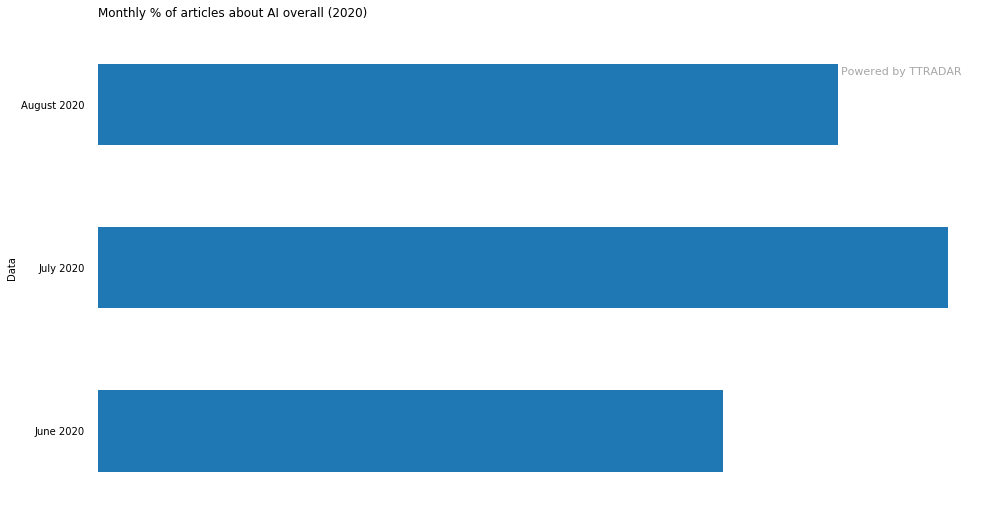

In [29]:
# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

# Horizontal Bar Plot 
df_monthly.loc[start:end, 'AI'].plot.barh()

ax.set_yticklabels(df_monthly.loc[start:end, 'AI'].index.strftime('%B %Y'))
  
# Remove axes splines 
for s in ['top', 'bottom', 'left', 'right']: 
    ax.spines[s].set_visible(False) 

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
  
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove x axis value
ax.xaxis.set_visible(False)

# Add Plot Title 
ax.set_title('Monthly % of articles about AI overall (2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)### % of AI Articles overall
  
# Show Plot 
plt.show() 

### 1.1.2 Yearly articles about selected technologies (2014 - 2020)

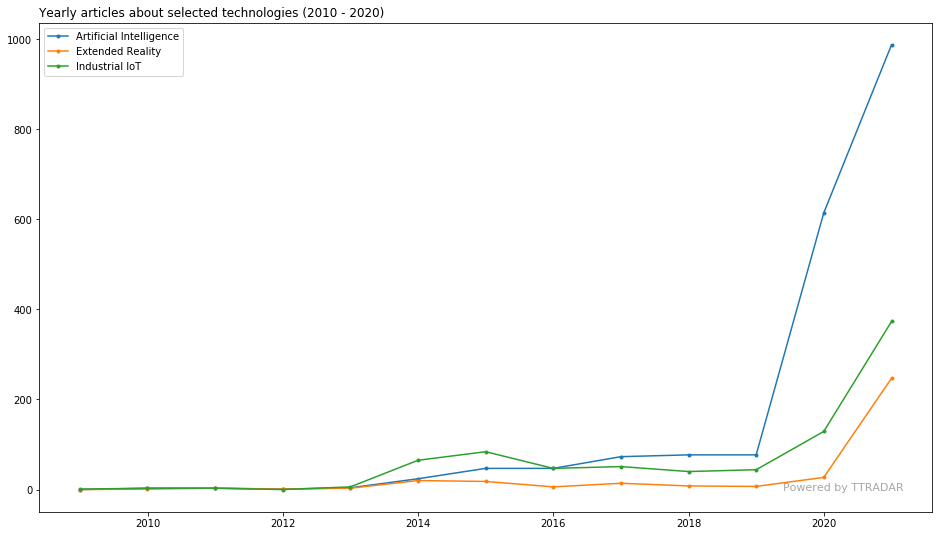

In [89]:
# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

x = df_yearly.index
y1 = df_yearly['AI']
y2 = df_yearly['AR / VR']
y3 = df_yearly['Industrial IoT']

plt.plot(x,y1,marker='.', label="Artificial Intelligence")
plt.plot(x,y2,marker='.', label='Extended Reality')
plt.plot(x,y3,marker='.', label='Industrial IoT')

# Add Plot Title 
ax.set_title('Yearly articles about selected technologies (2010 - 2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.legend()

# Show Plot 
plt.show() 

### 1.1.3 Mounthly articles about selected technologies (2010 - 2020)

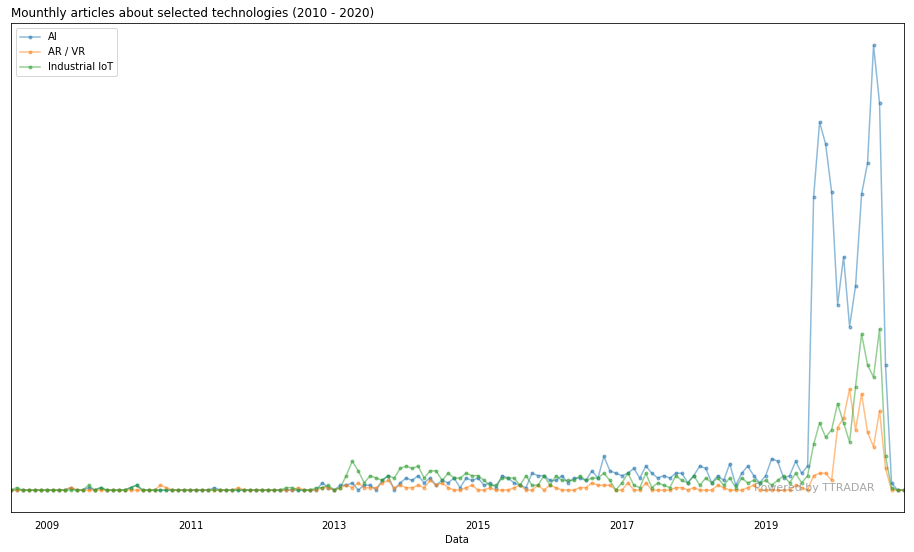

In [90]:
df_x = df_monthly#.loc[start:end]

# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

df_x['AI'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['AR / VR'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['Industrial IoT'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
    
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove y axis value
ax.yaxis.set_visible(False)

plt.legend()

# Add Plot Title 
ax.set_title('Mounthly articles about selected technologies (2010 - 2020)', loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

# Show Plot 
plt.show() 

### 1.1.4 Weekly articles about selected technologies (2020)

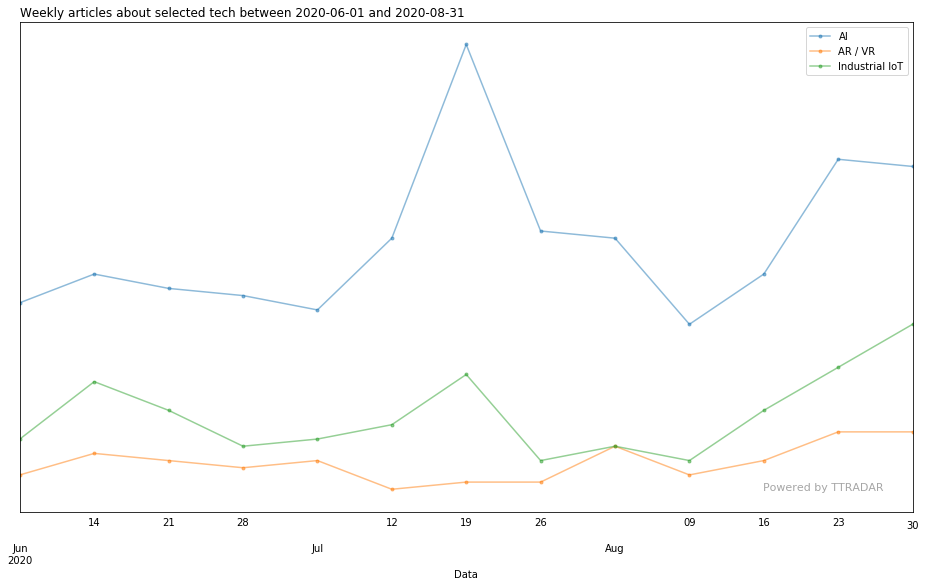

In [32]:
df_x = df_weekly.loc[start:end]

# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

df_x['AI'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['AR / VR'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)
df_x['Industrial IoT'].plot(marker='.', alpha=0.5, linestyle='-', subplots=False)

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
    
# Add padding between axes and labels 
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10) 

# Remove y axis value
ax.yaxis.set_visible(False)

plt.legend()

# Add Plot Title 
title = "Weekly articles about selected tech between %s and %s" % (start, end)
ax.set_title(title, loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

# Show Plot 
plt.show() 

## 1.2 Subset (Data, Tech, Application)

In [33]:
tech_appl = df_exploded[['Data', 'Tech', 'Application']]
tech_appl = tech_appl[~(tech_appl['Tech'].str.len() == 0)]
tech_appl = tech_appl[~(tech_appl['Application'].str.len() == 0)]
tech_appl = tech_appl.set_index(tech_appl['Data'])

In [34]:
print("Start %s End %s" % (start, end))

Start 2020-06-01 End 2020-08-31


In [35]:
tech_appl.count()

Data           2765
Tech           2765
Application    2765
dtype: int64

In [36]:
tech_appl = tech_appl.loc[start:end]

In [37]:
tech_appl.count()

Data           697
Tech           697
Application    697
dtype: int64

In [38]:
def explode_tech_application(df):
    data_tech = pd.concat([pd.Series(row['Data'], row['Tech'].split(', '))              
           for _, row in df.iterrows()])
    df1 = pd.DataFrame({'Data':data_tech.values, 'Tech':data_tech.index})

    data_appl = pd.concat([pd.Series(row['Data'], row['Application'].split(', '))              
           for _, row in df.iterrows()])

    df2 = pd.DataFrame({'Data':data_appl.values, 'Application':data_appl.index})

    res = pd.merge(df1,df2,on='Data',how='left')
    #res = df2
    res = res.sort_index()
    res = res.reset_index(drop=True)
    
    return res

In [39]:
tech_appl = explode_tech_application(tech_appl)
#tech_appl = df

In [40]:
tech_appl

,Data,Tech,Application
0,2020-06-01,Batteries,Energy Storage
1,2020-06-01,Batteries,Electric Vehicles
2,2020-06-01,Batteries,Contact Tracing
3,2020-06-01,Batteries,Mobile Communitations
4,2020-06-01,Batteries,Goods Delivery
...,...,...,...
14000,2020-08-31,Mobile,Advanced Analytics
14001,2020-08-31,Mobile,E-Commerce
14002,2020-08-31,Mobile,Security
14003,2020-08-31,Mobile,Cybersecurity


### 1.2.1 Top Applications in timeframe

In [41]:
count_series = tech_appl.groupby(['Application']).size()
applications = count_series.to_frame(name = 'Size').reset_index()
applications = applications.nlargest(10, 'Size')
applications.sort_values(by = 'Size', ascending=False, inplace=True)
applications.head(15)

,Application,Size
22,Energy Storage,1557
30,Mobile Communitations,1410
39,Security,846
3,Autonomous Vehicles,730
25,Goods Delivery,686
0,Advanced Analytics,612
14,Cybersecurity,594
20,Economy,582
41,Sharing Economy,539
31,Natural Language Processing,507


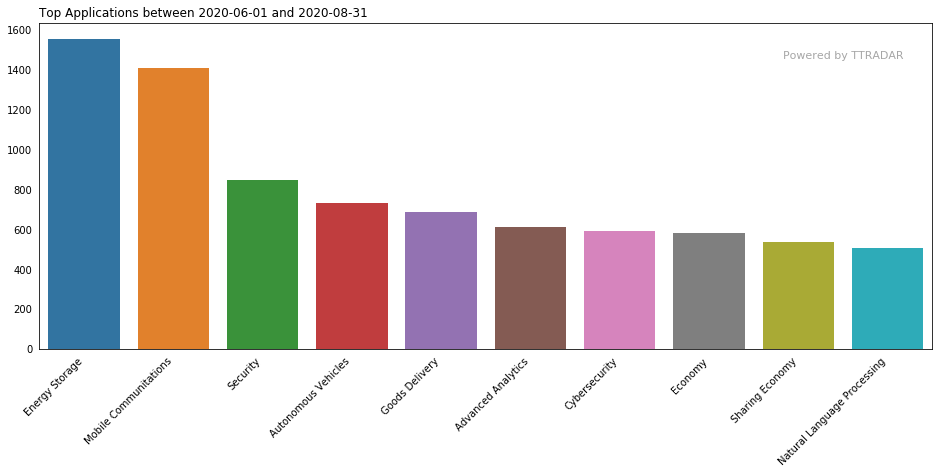

In [42]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Application', y='Size', data=applications)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
title = "Top Applications between %s and %s" % (start, end)
ax.set_title(title, loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### 1.2.2 Top applications for selected technology

In [43]:
technology = "Batteries"
#technology = "Autonomous Vehicles"

In [44]:
df_selected_tech = tech_appl.loc[tech_appl['Tech'] == technology]
count_series = df_selected_tech.groupby(['Tech', 'Application']).size()

df_selected_tech = count_series.to_frame(name = 'Size').reset_index()
df_selected_tech = df_selected_tech.nlargest(10, 'Size')
df_selected_tech.sort_values(by = 'Size', ascending=False, inplace=True)
df_selected_tech.head()

,Tech,Application,Size
21,Batteries,Energy Storage,320
29,Batteries,Mobile Communitations,168
38,Batteries,Security,106
37,Batteries,Renewables,91
19,Batteries,Economy,84


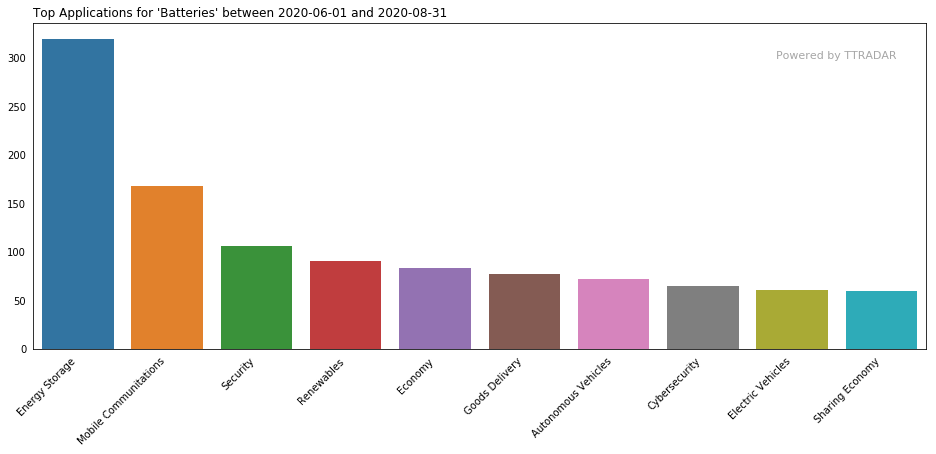

In [45]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Application', y='Size', data=df_selected_tech)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
title = "Top Applications for '%s' between %s and %s" % (technology, start, end)
ax.set_title(title, loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### 1.2.3 Top Technologies for selected application

In [46]:
#application = "Autonomous Vehicles"
application = "Energy Storage"

In [47]:
df_selected_application = tech_appl.loc[tech_appl['Application'] == application]
count_series = df_selected_application.groupby(['Tech', 'Application']).size()

df_selected_application = count_series.to_frame(name = 'Size').reset_index()
df_selected_application = df_selected_application.nlargest(10, 'Size')
df_selected_application.sort_values(by = 'Size', ascending=False, inplace=True)
df_selected_application.head()

,Tech,Application,Size
9,Mobile,Energy Storage,451
0,AI,Energy Storage,377
2,Batteries,Energy Storage,320
8,Industrial IoT,Energy Storage,159
7,Connectivity,Energy Storage,90


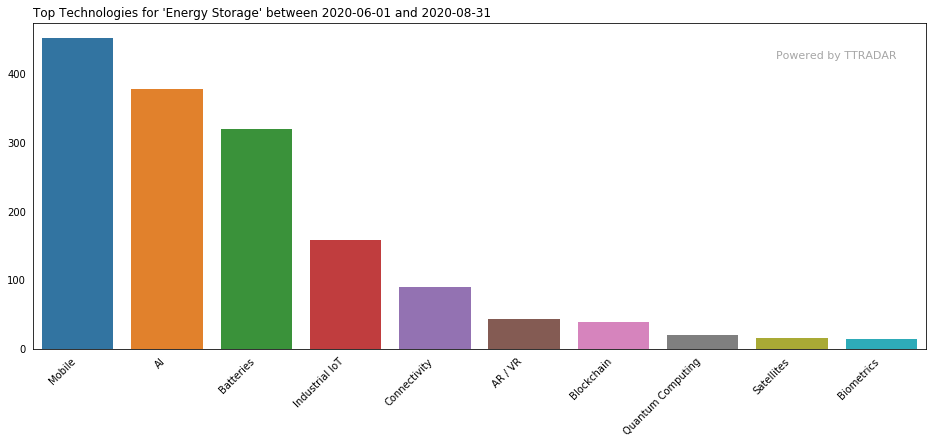

In [48]:
plt.figure(figsize=(16,6))
ax=sns.barplot(x='Tech', y='Size', data=df_selected_application)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")

# Remove x, y Ticks 
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 

ax.set_ylabel('')    
ax.set_xlabel('')

# Remove y axis value
#ax.yaxis.set_visible(False)

# Add Plot Title 
title = "Top Technologies for '%s' between %s and %s" % (application, start, end)
ax.set_title(title, loc ='left') 

ax.text(0.9, 0.9, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.show()

### 1.2.5 Weekly articles about energy related applications (2020)

In [49]:
df_applications = tech_appl

In [50]:
for c in df_applications['Application'].unique():
    df_applications[c] = df_applications['Application'].apply(lambda x: expand_column(x, c))

In [51]:
df_applications = df_applications.set_index(df_applications['Data'])
df_applications = df_applications.resample('W').sum()

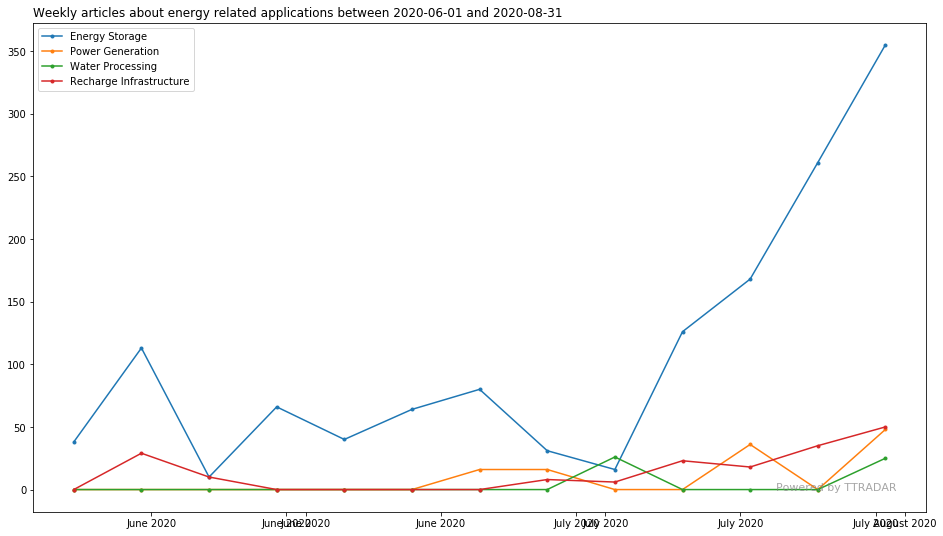

In [52]:
df_x = df_applications.loc[start:end]

# Figure Size 
fig, ax = plt.subplots(figsize =(16, 9)) 

x = df_x.index
y1 = df_x.loc[start:end, 'Energy Storage']
y2 = df_x.loc[start:end, 'Power Generation']
y3 = df_x.loc[start:end, 'Water Processing']
y4 = df_x.loc[start:end, 'Recharge Infrastructure']

plt.plot(x,y1,marker='.', label="Energy Storage")
plt.plot(x,y2,marker='.', label='Power Generation')
plt.plot(x,y3,marker='.', label='Water Processing')
plt.plot(x,y4,marker='.', label='Recharge Infrastructure')

ax.set_xticklabels(df_x.index.strftime('%B %Y'))

# Add Plot Title 
title = "Weekly articles about energy related applications between %s and %s" % (start, end)
ax.set_title(title, loc ='left', ) 
  
# Add Text watermark 
ax.text(0.9, 0.05, 'Powered by TTRADAR', 
        fontsize = 11, color ='grey', alpha = 0.7,
        horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes)

plt.legend()

# Show Plot 
plt.show() 

### 1.2.6 Technologies related to each Application

In [53]:
df_vertical_tech = tech_appl[['Tech', 'Application']]
df_vertical_tech['Value'] = 1

C:\Users\edoardo.esposito\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
df_vertical_tech

,Tech,Application,Value
0,Batteries,Energy Storage,1
1,Batteries,Electric Vehicles,1
2,Batteries,Contact Tracing,1
3,Batteries,Mobile Communitations,1
4,Batteries,Goods Delivery,1
...,...,...,...
14000,Mobile,Advanced Analytics,1
14001,Mobile,E-Commerce,1
14002,Mobile,Security,1
14003,Mobile,Cybersecurity,1


In [55]:
df_vertical_tech_pivot = pd.pivot_table(df_vertical_tech, 
                                        values=["Value"], 
                                        index=["Tech"], 
                                        columns=["Application"], 
                                        fill_value=0, 
                                        aggfunc='count', 
                                        margins=False) 

In [56]:
df_vertical_tech_pivot

Value                     \
Application               Advanced Analytics Antispam Astronomy   
Tech                                                              
AI                                       212       22         5   
AR / VR                                   21        2         1   
Batteries                                 52       10         2   
Big Data                                   5        0         0   
Biometrics                                 9        1         0   
Blockchain                                14        3         1   
Brain Computer Interfaces                 13        0         2   
Connectivity                              67        9         3   
Industrial IoT                            66       10         3   
Mobile                                   129       14         2   
Quantum Computing                          6        0         0   
Satellites                                11        1         1   
Wearables                                  7        1         0   

                                                                    \
Application               Autonomous Vehicles Behavioural Sciences   
Tech                                                                 
AI                                        282                   50   
AR / VR                                    14                    6   
Batteries                                  72                   22   
Big Data                                    1                    0   
Biometrics                                  6                    0   
Blockchain                                 33                    3   
Brain Computer Interfaces                  11                    0   
Connectivity                               41                   10   
Industrial IoT                             71                   18   
Mobile                                    171                   52   
Quantum Computing                           9                    5   
Satellites                                 12                    4   
Wearables                                   7                    2   

                                                                   \
Application               Bio Engineering Chatbot Computer Vision   
Tech                                                                
AI                                    103      52              93   
AR / VR                                 8       3               6   
Batteries                              25       4              20   
Big Data                                4       0               0   
Biometrics                              1       1               3   
Blockchain                              6       4               7   
Brain Computer Interfaces               8       1               2   
Connectivity                           22       3              22   
Industrial IoT                         25      15              24   
Mobile                                 64      32              48   
Quantum Computing                       5       0               3   
Satellites                              5       1               1   
Wearables                               0       0               4   

                                                        ...             \
Application               Contact Tracing Crowdfunding  ... Smart Home   
Tech                                                    ...              
AI                                     70           27  ...          5   
AR / VR                                10            0  ...          1   
Batteries                              31            4  ...          4   
Big Data                                2            0  ...          0   
Biometrics                              2            1  ...          1   
Blockchain                             12            3  ...          1   
Brain Computer Interfaces               4            1  ...          0   


Text(0.5, 1.0, 'Technologies related to each Application')

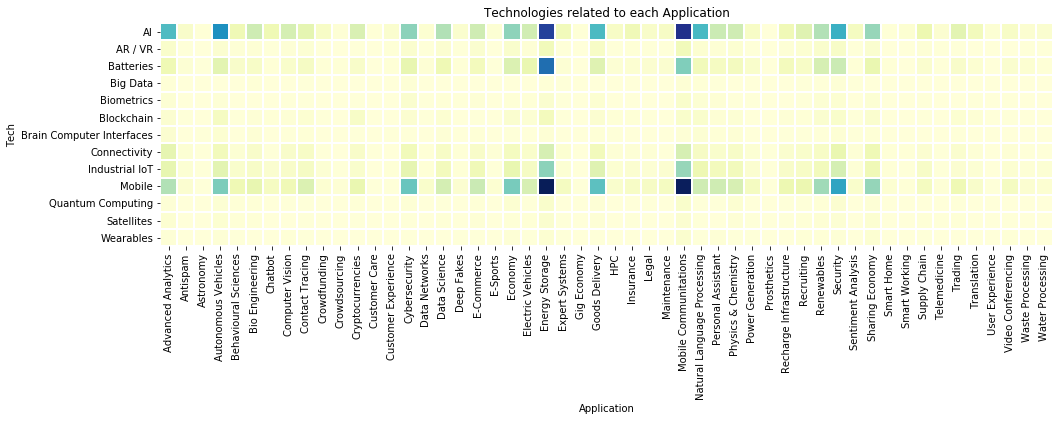

In [57]:
plt.figure(figsize=(16,16))
sns.heatmap(df_vertical_tech_pivot['Value'],
            linewidths=1, 
            annot=False ,
            vmin=0.01,
            cmap='YlGnBu', 
            cbar=False, square=True)
plt.title('Technologies related to each Application')

In [58]:
tech_appl

,Data,Tech,Application,Energy Storage,Electric Vehicles,Contact Tracing,Mobile Communitations,Goods Delivery,Autonomous Vehicles,Data Science,...,Antispam,E-Sports,User Experience,Power Generation,Maintenance,Customer Care,Water Processing,Video Conferencing,Crowdsourcing,Gig Economy
0,2020-06-01,Batteries,Energy Storage,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-06-01,Batteries,Electric Vehicles,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-06-01,Batteries,Contact Tracing,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-06-01,Batteries,Mobile Communitations,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-06-01,Batteries,Goods Delivery,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14000,2020-08-31,Mobile,Advanced Analytics,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14001,2020-08-31,Mobile,E-Commerce,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14002,2020-08-31,Mobile,Security,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14003,2020-08-31,Mobile,Cybersecurity,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
dd=pd.get_dummies(tech_appl['Tech'])

list = []
for i in tech_appl['Tech'].unique():
    list.append(dd[i].sum())

[Text(0.5, 0, 'Number of tech')]

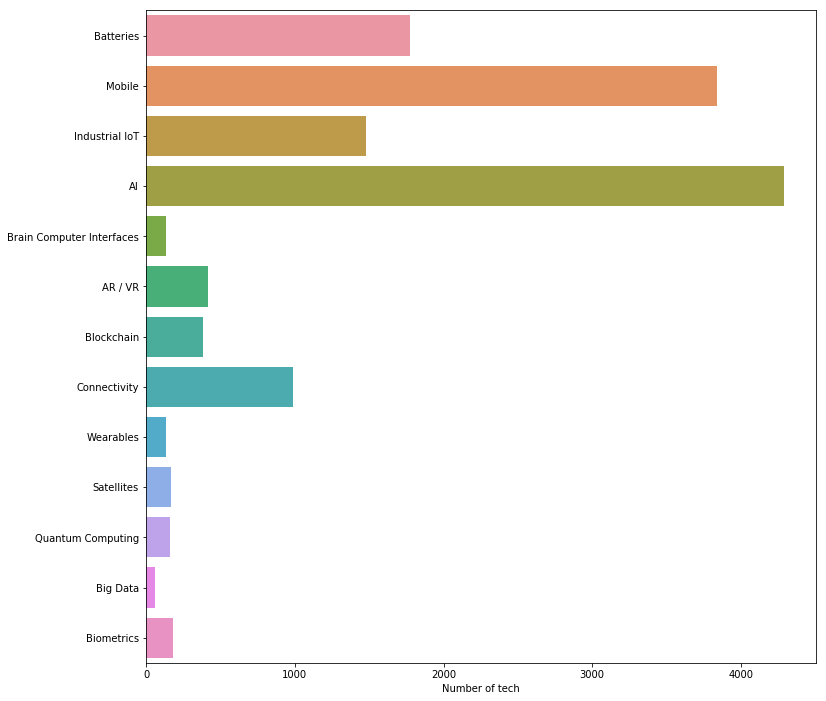

In [79]:
plt.figure(figsize=(12, 12))
ax=sns.barplot(y=tech_appl['Tech'].unique(),x=list,data=tech_appl)
ax.set(xlabel='Number of tech')

In [94]:
tech_appl['Application'].replace("", float('NaN'), inplace=True)
data = tech_appl.dropna(subset = ["Application"])
data = data[data.groupby('Application').Application.transform('count')>100].copy() 

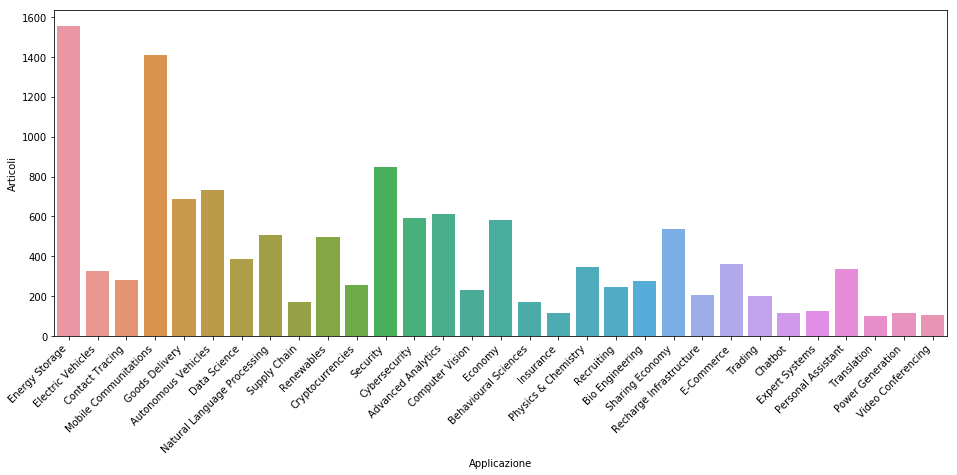

In [88]:
plt.figure(figsize=(16,6))
ax=sns.countplot(data['Application'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel("Articoli")
plt.xlabel("Applicazione")
plt.show()